In [5]:
#imports
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

#sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.metrics import mean_squared_error, f1_score, recall_score, precision_score, confusion_matrix, ConfusionMatrixDisplay
# Imports
import torch
import torch.nn.functional as F  # Parameterless functions, like (some) activation functions
import torchvision.datasets as datasets  # Standard datasets
import torchvision.transforms as transforms  # Transformations we can perform on our dataset for augmentation

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline





In [8]:
#read the data 
#algorithm to read all the files

'''
for folder in this folder:
    read xelasensor1.csv
    read sliplabel.csv
    concat it in a single dataframe along axis = 0

print the dataframe
'''
import os

directory = 'CNN-GradCAM/train2dof'
directory2 = 'train2dof'

def read_file(detect_or_pred, n = None):

    #store all directories in a list
    list_xela_allfiles = []
    list_sliplabel_allfiles = []

    for root, subdirectories, files in os.walk(directory):
        for sdirectory in subdirectories:

            #subdirectory with absolute path
            subdirectory = '{}/{}'.format(root, sdirectory)

            #read specific files in the subdirectory
            for file in os.listdir(subdirectory):
            
                if file.endswith("sensor1.csv"):
                    df = pd.read_csv('{}/{}'.format(subdirectory, file), index_col=None, header=0)
                    
                    if detect_or_pred ==0:
                        list_xela_allfiles.append(df)
                    elif detect_or_pred ==1 and n is not None:
                        list_xela_allfiles.append(df[:-n])

                if file.endswith("label.csv"):
                    df = pd.read_csv('{}/{}'.format(subdirectory, file), index_col=None, header=0)
                    if detect_or_pred ==0:
                        list_sliplabel_allfiles.append(df)
                    elif detect_or_pred ==1 and n is not None: 
                        list_sliplabel_allfiles.append(df[n:])

    return list_xela_allfiles, list_sliplabel_allfiles
                    


# METRICS DEFINITION

In [ ]:

def detection_metrics(xela_test, sliplabel_test, model_type, acc = None):
    #predict using the holdout set (DONE)
    predicted = model_type(xela_test).detach().numpy()
    predicted_cls = predicted.round()

    #Plot the loss values against number of epochs (DONE)
    #validation test (DONE)

    #Print the accuracy
    accuracy = accuracy_score(sliplabel_test.numpy(), predicted_cls)
    print(f'Accuracy for slip detection is {accuracy}')

    #Print the fscore
    fscore = f1_score(sliplabel_test.numpy(), predicted_cls, average='macro')
    print(f'Fscore for slip detection is {fscore}')

    #print the Precision
    precision = precision_score(sliplabel_test.numpy(), predicted_cls, average='macro')
    print(f'Precision for slip detection is {precision}')

    #print the Recall
    recall = recall_score(sliplabel_test.numpy(), predicted_cls, average='macro')
    print(f'Recall for slip detection is {recall}')

def slip_metrics(n, xela_test, sliplabel_test, modeltype):
    #predict using the holdout set (DONE)
    predicted = modeltype(xela_test).detach().numpy()
    predicted_cls = predicted.round()

    #Plot the loss values against number of epochs (DONE)
    #validation test (DONE)

    #Print the accuracy
    x = 0
    for i in range(predicted_cls.shape[0]):
        if predicted_cls[i].item() == sliplabel_test[i].item():
            x += 1

    accuracy = x/ float(sliplabel_test.shape[0])
    print(f'Accuracy for slip prediction for (t+{n}) is {accuracy}')

    #Print the fscore
    fscore = f1_score(sliplabel_test.numpy(), predicted_cls, average='macro')
    print(f'Fscore for slip prediction for (t+{n}) is {fscore}')

    #print the Precision
    precision = precision_score(sliplabel_test.numpy(), predicted_cls, average='macro')
    print(f'Precision for slip prediction for (t+{n}) is {precision}')

    #print the Recall
    recall = recall_score(sliplabel_test.numpy(), predicted_cls, average='macro')
    print(f'Recall for slip prediction for (t+{n}) is {recall}')



# SLIP DETECTION


In [9]:
#concat the list of xela_allfiles and sliplabel_allfiles across axis = 0
list_xela_allfiles, list_sliplabel_allfiles = read_file(0)
pd_xela_allfiles = pd.concat(list_xela_allfiles, axis=0, ignore_index=True)
pd_sliplabel_allfiles = pd.concat(list_sliplabel_allfiles, axis=0, ignore_index=True)
pd_sliplabel_allfiles = pd_sliplabel_allfiles['slip']


In [ ]:

#dealing with imbalanced data using SMOTE
from imblearn.over_sampling import SMOTE
# Resampling the minority class. The strategy can be changed as required.
sm = SMOTE(sampling_strategy='minority', random_state=42)
# Fit the model to generate the data.
pd_xela_allfiles, pd_sliplabel_allfiles = sm.fit_resample(pd_xela_allfiles, pd_sliplabel_allfiles)
oversampled = pd.concat([pd.DataFrame(pd_xela_allfiles), pd.DataFrame(pd_sliplabel_allfiles)], axis=1)


In [11]:
#convert to numpy values
pd_xela_allfiles = np.array(pd_xela_allfiles.values)
pd_sliplabel_allfiles = np.array(pd_sliplabel_allfiles.values)



In [12]:
#split the data into train and test
xela_train, xela_test, sliplabel_train, sliplabel_test = train_test_split(pd_xela_allfiles, pd_sliplabel_allfiles, shuffle=True, test_size=0.1, random_state=42)

In [13]:
#split into validation and holdout
xela_train, xela_valid, sliplabel_train, sliplabel_valid = train_test_split(xela_train, sliplabel_train, shuffle = True, test_size=0.3, random_state=42)

In [36]:
xela_valid.shape

torch.Size([114802, 48])

In [14]:
#scale the data
sc = StandardScaler()
xela_train = sc.fit_transform(xela_train)
xela_test = sc.transform(xela_test)
xela_valid = sc.transform(xela_valid)

In [15]:
#convert to tensor values
xela_train = torch.from_numpy(xela_train.astype(np.float32))
xela_test = torch.from_numpy(xela_test.astype(np.float32))

sliplabel_train = torch.from_numpy(sliplabel_train.astype(np.float32))
sliplabel_test = torch.from_numpy(sliplabel_test.astype(np.float32))

xela_valid = torch.from_numpy(xela_valid.astype(np.float32))


sliplabel_valid = torch.from_numpy(sliplabel_valid.astype(np.float32))


#reshape the y tensor
sliplabel_train = sliplabel_train.view(sliplabel_train.shape[0], 1)
sliplabel_test = sliplabel_test.view(sliplabel_test.shape[0], 1)

sliplabel_valid = sliplabel_valid.view(sliplabel_valid.shape[0], 1)




In [20]:
#Apply batch training on the training/validation data
class Batchdata(Dataset):
    def __init__(self, xela_train, sliplabel_train, xela_valid, sliplabel_valid, valid = None):
        self.x = xela_train
        self.y = sliplabel_train
        self.xvalid = xela_valid
        self.yvalid = sliplabel_valid
        self.valid = valid


    def __len__(self):
        if self.valid == True:
            return self.xvalid.shape[0]
        else:
            return self.x.shape[0]

    def __getitem__(self, idx):

        if self.valid == True:
            return self.xvalid[idx], self.yvalid[idx]
        else:
            return self.x[idx], self.y[idx]

dataset = Batchdata(xela_train, sliplabel_train, xela_valid, sliplabel_valid)
dataset2 = Batchdata(xela_train, sliplabel_train, xela_valid, sliplabel_valid, valid = True)

xelaloader = DataLoader(dataset = dataset, batch_size=32, shuffle=True)
xelaloadervalid = DataLoader(dataset = dataset2, batch_size=32, shuffle=True)


In [21]:
#create the NN class

inputsize = xela_train.shape[1]
outputsize = 1
hiddensize1 = 16
hiddensize2 = 10

class NeuralNet(nn.Module):
    def __init__(self, inputsize, hiddensize1, hiddensize2, outputsize):
        super(NeuralNet, self).__init__()

        self.l1 = nn.Linear(inputsize, hiddensize1)
        self.relu = nn.ReLU()
        self.l2 = nn.Linear(hiddensize1, hiddensize2)
        self.l3 = nn.Linear(hiddensize2, outputsize)
        # self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out = self.l1(x)
        out = self.relu(out)
        out = self.l2(out)
        out = self.relu(out)
        out = self.l3(out)
        out = torch.sigmoid(out)
        return(out)




In [31]:
model = NeuralNet(inputsize, hiddensize1, hiddensize2, outputsize).to('cpu')
model.load_state_dict(torch.load('models/DNN.pth', map_location=torch.device('cpu')))

<All keys matched successfully>

In [32]:
y_test = sliplabel_valid
model.eval()  # set model to evaluation mode
with torch.no_grad():  # disable gradient computation
    y_pred = model(xela_valid)
    y_pred = np.round(y_pred)

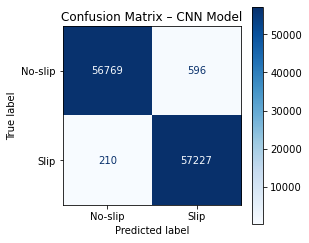

In [ ]:

cm = confusion_matrix(y_test, y_pred)

class_names = ["No-slip", "Slip"]  # 0 → No-slip, 1 → Slip

# 3. Display with labels and title
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

# 4. Plot 
fig, ax = plt.subplots(figsize=(4, 4))
disp.plot(cmap='Blues', ax=ax)
plt.title("Confusion Matrix SMOTE-NN Model")
plt.show()

In [ ]:
#Train with batch training
model = NeuralNet(inputsize, hiddensize1, hiddensize2, outputsize)

#Construct the loss and Optimizer
learning_rate = 0.001
loss = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

n_iters = 100

train_loss = []
valid_loss = []

t_loss = []
v_loss = []

t_acc = []
v_acc = []

t_acc_t = []
v_acc_t = []


#Train the model

for epoch in range(n_iters):
    #Train per batch
    total = 0
    correct = 0
    l_xelaloader = 0

    model.train()
    for (x, y) in (xelaloader):
      
        #empty the gradients
        optimizer.zero_grad()
        
        #Forward pass
        y_pred = model(x)

        #compute the loss
        l = loss(y_pred, y)

        #compute the gradient
        l.backward()

        #update the weights
        optimizer.step()

        #append each loss per batch
        train_loss.append(l.item())

        #accuracy
        total += y.size(0)
        correct += y_pred.round().eq(y).sum().item()
        l_xelaloader += x.shape[0]
        
    
    t_acc = correct/l_xelaloader
    t_acc_t.append(t_acc)

    total = 0
    correct = 0
    l_xelaloader = 0

    #calculate and plot the validation loss
    model.eval()
    for (x,y) in (xelaloadervalid):
        y_pred_test = model(x)
        lv = loss(y_pred_test, y)

        #append each loss per batch
        valid_loss.append(lv.item())

        #accuracy
        total += y.size(0)
        correct += y_pred_test.round().eq(y).sum().item()
        l_xelaloader += x.shape[0]
    
    v_acc = correct/l_xelaloader
    v_acc_t.append(v_acc)

    #append the total loss and accuracy per epoch
    t_loss.append(np.mean(train_loss))
    v_loss.append(np.mean(valid_loss))


    print(f'For training epoch {epoch+1}, loss ={l:.8f}', f'For validation epoch {epoch+1}, loss ={lv:.8f}'  )

torch.save(model.state_dict(), "DNN.pth",_use_new_zipfile_serialization=False)


For training epoch 1, loss =0.12242735 For validation epoch 1, loss =0.11427331
For training epoch 2, loss =0.07393983 For validation epoch 2, loss =0.01158634
For training epoch 3, loss =0.13840209 For validation epoch 3, loss =0.02297569
For training epoch 4, loss =0.09802894 For validation epoch 4, loss =0.14555718
For training epoch 5, loss =0.00711670 For validation epoch 5, loss =0.01778943
For training epoch 6, loss =0.00263717 For validation epoch 6, loss =0.02079939
For training epoch 7, loss =0.01130870 For validation epoch 7, loss =0.00609502
For training epoch 8, loss =0.01599028 For validation epoch 8, loss =0.08565203
For training epoch 9, loss =0.22539422 For validation epoch 9, loss =0.03270976
For training epoch 10, loss =0.06984029 For validation epoch 10, loss =0.03342824
For training epoch 11, loss =0.00904876 For validation epoch 11, loss =0.00109306
For training epoch 12, loss =0.02612330 For validation epoch 12, loss =0.00412355
For training epoch 13, loss =0.001

In [ ]:

#Plot the loss per epoch for training and validation

#create a subplot of 3 plots

fig, ax = plt.subplots(1,2,figsize=(15,5))

#set labels
ax[0].set_xlabel('Epochs', color = 'black')
ax[0].set_ylabel('Loss', color = 'black')
ax[1].set_xlabel('Epochs', color = 'black')
ax[1].set_ylabel('Accuracy', color = 'black')


ax[0].plot(t_loss, label='Train Loss', color='red', linewidth=2, linestyle='dashed')
ax[0].plot(v_loss, label='Validation Loss', color = 'blue')
ax[1].plot(t_acc_t, label = 'Train Accuracy', color = 'orange')
ax[1].plot(v_acc_t, label = 'Validation Accuracy', color = 'green')

#set legends
ax[0].legend()
ax[1].legend()


In [ ]:
#Metrics after Batch Training
print('Metrics after Batch Training')
detection_metrics(xela_valid, sliplabel_valid, model_type = model)

# SLIP PREDICTION

In [ ]:
#concat the list of xela_allfiles and sliplabel_allfiles across axis = 0
n = 20 #-> Define the number of time steps for prediction
list_xela_allfiles, list_sliplabel_allfiles = read_file(1, n)
pd_xela_allfiles = pd.concat(list_xela_allfiles, axis=0, ignore_index=True)
pd_sliplabel_allfiles = pd.concat(list_sliplabel_allfiles, axis=0, ignore_index=True)
pd_sliplabel_allfiles = pd_sliplabel_allfiles['slip']


In [ ]:
#dealing with imbalanced data using SMOTE
from imblearn.over_sampling import SMOTE
# Resampling the minority class. The strategy can be changed as required.
sm = SMOTE(sampling_strategy='minority', random_state=42)
# Fit the model to generate the data.
pd_xela_allfiles, pd_sliplabel_allfiles = sm.fit_resample(pd_xela_allfiles, pd_sliplabel_allfiles)
oversampled = pd.concat([pd.DataFrame(pd_xela_allfiles), pd.DataFrame(pd_sliplabel_allfiles)], axis=1)


In [ ]:
#convert to numpy values
pd_xela_allfiles = np.array(pd_xela_allfiles.values)
pd_sliplabel_allfiles = np.array(pd_sliplabel_allfiles.values)



In [ ]:
#split the data into train and validation
xela_train, xela_test, sliplabel_train, sliplabel_test = train_test_split(pd_xela_allfiles, pd_sliplabel_allfiles, shuffle=True, test_size=0.1, random_state=42)

In [ ]:
#split into validation and holdout
xela_train, xela_valid, sliplabel_train, sliplabel_valid = train_test_split(xela_train, sliplabel_train, shuffle = True, test_size=0.3, random_state=42)

In [ ]:
#scale the data
sc = StandardScaler()
xela_train = sc.fit_transform(xela_train)
xela_test = sc.transform(xela_test)
xela_valid = sc.transform(xela_valid)

#convert to tensor values
xela_train = torch.from_numpy(xela_train.astype(np.float32))
xela_test = torch.from_numpy(xela_test.astype(np.float32))

sliplabel_train = torch.from_numpy(sliplabel_train.astype(np.float32))
sliplabel_test = torch.from_numpy(sliplabel_test.astype(np.float32))

xela_valid = torch.from_numpy(xela_valid.astype(np.float32))


sliplabel_valid = torch.from_numpy(sliplabel_valid.astype(np.float32))


#reshape the y tensor
sliplabel_train = sliplabel_train.view(sliplabel_train.shape[0], 1)
sliplabel_test = sliplabel_test.view(sliplabel_test.shape[0], 1)

sliplabel_valid = sliplabel_valid.view(sliplabel_valid.shape[0], 1)

In [ ]:
#Apply batch division on the training/validation data
class Batchdata(Dataset):
    def __init__(self, xela_train, sliplabel_train, xela_valid, sliplabel_valid, valid = None):
        self.x = xela_train
        self.y = sliplabel_train
        self.xvalid = xela_valid
        self.yvalid = sliplabel_valid
        self.valid = valid


    def __len__(self):
        if self.valid == True:
            return self.xvalid.shape[0]
        else:
            return self.x.shape[0]

    def __getitem__(self, idx):

        if self.valid == True:
            return self.xvalid[idx], self.yvalid[idx]
        else:
            return self.x[idx], self.y[idx]


#DetAILS FOR BATCH Training
dataset = Batchdata(xela_train, sliplabel_train, xela_valid, sliplabel_valid)
dataset2 = Batchdata(xela_train, sliplabel_train, xela_valid, sliplabel_valid, valid = True)

xelaloader = DataLoader(dataset = dataset, batch_size=32, shuffle=True)
xelaloadervalid = DataLoader(dataset = dataset2, batch_size=32, shuffle=True)


In [ ]:
#Build the model parameters
inputsize = xela_train.shape[1]
outputsize = 1
hiddensize1 = 16
hiddensize2 = 10

class NeuralNet(nn.Module):
    def __init__(self, inputsize, hiddensize1, hiddensize2, outputsize):
        super(NeuralNet, self).__init__()

        self.l1 = nn.Linear(inputsize, hiddensize1)
        self.relu = nn.ReLU()
        self.l2 = nn.Linear(hiddensize1, hiddensize2)
        self.l3 = nn.Linear(hiddensize2, outputsize)
        # self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out = self.l1(x)
        out = self.relu(out)
        out = self.l2(out)
        out = self.relu(out)
        out = self.l3(out)
        out = torch.sigmoid(out)
        return(out)



In [ ]:
#Train with batch training
model = NeuralNet(inputsize, hiddensize1, hiddensize2, outputsize)

#Construct the loss and Optimizer
learning_rate = 0.01
loss = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

n_iters = 100

train_loss = []
valid_loss = []

t_loss = []
v_loss = []

t_acc = []
v_acc = []

t_acc_t = []
v_acc_t = []

total = 0
correct = 0
l_xelaloader = 0

#Train the model

for epoch in range(n_iters):
    #Train per batch
    total = 0
    correct = 0
    l_xelaloader = 0
    
    model.train()
    for (x, y) in (xelaloader):
      
        #empty the gradients
        optimizer.zero_grad()
        
        #Forward pass
        y_pred = model(x)

        #compute the loss
        l = loss(y_pred, y)

        #compute the gradient
        l.backward()

        #update the weights
        optimizer.step()

        #append each loss per batch
        train_loss.append(l.item())

        #accuracy
        total += y.size(0)
        correct += y_pred.round().eq(y).sum().item()
        l_xelaloader += x.shape[0]
     
    
    t_acc = correct/l_xelaloader
    t_acc_t.append(t_acc)

    total = 0
    correct = 0
    l_xelaloader = 0

    #calculate and plot the validation loss
    model.eval()
    for (x,y) in (xelaloadervalid):
        y_pred_test = model(x)
        lv = loss(y_pred_test, y)

        #append each loss per batch
        valid_loss.append(lv.item())

        #accuracy
        total += y.size(0)
        correct += y_pred_test.round().eq(y).sum().item()
        l_xelaloader += x.shape[0]
    
    v_acc = correct/l_xelaloader
    v_acc_t.append(v_acc)

    #append the total loss and accuracy per epoch
    t_loss.append(np.mean(train_loss))
    

    v_loss.append(np.mean(valid_loss))


    print(f'For training epoch {epoch+1}, loss ={l:.8f}', f'For validation epoch {epoch+1}, loss ={lv:.8f}'  )


In [ ]:

#Plot the loss per epoch for training and validation

#create a subplot of 3 plots

fig, ax = plt.subplots(1,2,figsize=(15, 5))

#set labels

ax[0].set_xlabel('Epochs', color = 'black')
ax[0].set_ylabel('Loss', color = 'black')
ax[1].set_xlabel('Epochs', color = 'black')
ax[1].set_ylabel('Loss', color = 'black')

ax[0].plot(t_loss, label='Train Loss', color='red', linewidth=2, linestyle='dashed')
ax[0].plot(v_loss, label='Validation Loss', color = 'blue')
ax[1].plot(t_acc_t, label = 'Train Accuracy', color = 'orange')
ax[1].plot(v_acc_t, label = 'Validation Accuracy', color = 'green')

#set legends
ax[0].legend()
ax[1].legend()



In [ ]:
#Metrics after batch training for slip prediction
print('Metrics after batch training for slip prediction')
slip_metrics(n, xela_test, sliplabel_test, modeltype = model)